### HOW TO MAP FLOODWATER FROM RADAR IMAGERY USING SEMANTIC SEGMENTATION - BENCHMARK

https://www.drivendata.co/blog/detect-floodwater-benchmark/

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import rasterio
from pandas_path import path

# This is where our downloaded images and metadata live locally
DATA_PATH = Path('/home/paul/Documents/drivendata/stac-overflow/data/external/')

In [2]:
train_metadata = pd.read_csv(
    DATA_PATH / "flood-training-metadata.csv", parse_dates=["scene_start"]
)

In [3]:
train_metadata.shape

(1084, 6)

In [4]:
train_metadata

,image_id,chip_id,flood_id,polarization,location,scene_start
0,awc00_vh,awc00,awc,vh,Bolivia,2018-02-15
1,awc00_vv,awc00,awc,vv,Bolivia,2018-02-15
2,awc01_vh,awc01,awc,vh,Bolivia,2018-02-15
3,awc01_vv,awc01,awc,vv,Bolivia,2018-02-15
4,awc02_vh,awc02,awc,vh,Bolivia,2018-02-15
...,...,...,...,...,...,...
1079,wvy29_vv,wvy29,wvy,vv,UK,2019-02-15
1080,wvy30_vh,wvy30,wvy,vh,UK,2019-02-15
1081,wvy30_vv,wvy30,wvy,vv,UK,2019-02-15
1082,wvy31_vh,wvy31,wvy,vh,UK,2019-02-15


In [5]:
train_metadata["feature_path"] = (
    str(DATA_PATH / "train_features")
    / train_metadata.image_id.path.with_suffix(".tif").path
)

train_metadata["label_path"] = (
    str(DATA_PATH / "train_labels")
    / train_metadata.chip_id.path.with_suffix(".tif").path
)

In [6]:
image_path = train_metadata.feature_path[0]

In [7]:
with rasterio.open(image_path) as img:
    metadata = img.meta
    bounds = img.bounds
    data = img.read(1)

In [8]:
metadata

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': 0.0,
 'width': 512,
 'height': 512,
 'count': 1,
 'crs': CRS.from_epsg(32720),
 'transform': Affine(10.0, 0.0, 314030.0,
        0.0, -10.0, 8585890.0)}

In [9]:
def scale_img(matrix):
    """
    Returns a scaled (H, W, D) image that is visually inspectable.
    Image is linearly scaled between min_ and max_value, by channel.

    Args:
        matrix (np.array): (H, W, D) image to be scaled

    Returns:
        np.array: Image (H, W, 3) ready for visualization
    """
    # Set min/max values
    min_values = np.array([-23, -28, 0.2])
    max_values = np.array([0, -5, 1])

    # Reshape matrix
    w, h, d = matrix.shape
    matrix = np.reshape(matrix, [w * h, d]).astype(np.float64)

    # Scale by min/max
    matrix = (matrix - min_values[None, :]) / (
        max_values[None, :] - min_values[None, :]
    )
    matrix = np.reshape(matrix, [w, h, d])

    # Limit values to 0/1 interval
    return matrix.clip(0, 1)


def create_false_color_composite(path_vv, path_vh):
    """
    Returns a S1 false color composite for visualization.

    Args:
        path_vv (str): path to the VV band
        path_vh (str): path to the VH band

    Returns:
        np.array: image (H, W, 3) ready for visualization
    """
    # Read VV/VH bands
    with rasterio.open(path_vv) as vv:
        vv_img = vv.read(1)
    with rasterio.open(path_vh) as vh:
        vh_img = vh.read(1)

    # Stack arrays along the last dimension
    s1_img = np.stack((vv_img, vh_img), axis=-1)

    # Create false color composite
    img = np.zeros((512, 512, 3), dtype=np.float32)
    img[:, :, :2] = s1_img.copy()
    img[:, :, 2] = s1_img[:, :, 0] / s1_img[:, :, 1]

    return scale_img(img)


def display_random_chip(random_state):
    """
    Plots a 3-channel representation of VV/VH polarizations as a single chip (image 1).
    Overlays a chip's corresponding water label (image 2).

    Args:
        random_state (int): random seed used to select a chip

    Returns:
        plot.show(): chip and labels plotted with pyplot
    """
    f, ax = plt.subplots(1, 2, figsize=(9, 9))

    # Select a random chip from train_metadata
    random_chip = train_metadata.chip_id.sample(random_state=random_state).values[0]
    chip_df = train_metadata[train_metadata.chip_id == random_chip]

    # Extract paths to image files
    vv_path = chip_df[chip_df.polarization == "vv"].feature_path.values[0]
    vh_path = chip_df[chip_df.polarization == "vh"].feature_path.values[0]
    label_path = chip_df.label_path.values[0]

    # Create false color composite
    s1_img = create_false_color_composite(vv_path, vh_path)

    # Visualize features
    ax[0].imshow(s1_img)
    ax[0].set_title("S1 Chip", fontsize=14)

    # Load water mask
    with rasterio.open(label_path) as lp:
        lp_img = lp.read(1)

    # Mask missing data and 0s for visualization
    label = np.ma.masked_where((lp_img == 0) | (lp_img == 255), lp_img)

    # Visualize water label
    ax[1].imshow(s1_img)
    ax[1].imshow(label, cmap="cool", alpha=1)
    ax[1].set_title("S1 Chip with Water Label", fontsize=14)

    plt.tight_layout(pad=5)
    plt.show()

/home/paul/anaconda3/envs/stac-overflow/lib/python3.8/site-packages/matplotlib/image.py:443: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/paul/anaconda3/envs/stac-overflow/lib/python3.8/site-packages/matplotlib/image.py:444: UserWarning: Warning: converting a masked element to nan.
  vmid = np.float64(self.norm.vmin) + dv / 2


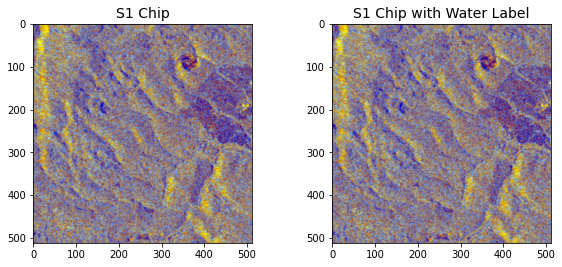

In [10]:
display_random_chip(9)

--

In [11]:
import random
random.seed(9)  # set a seed for reproducibility

# Sample 3 random floods for validation set
flood_ids = train_metadata.flood_id.unique().tolist()
val_flood_ids = random.sample(flood_ids, 3)
val_flood_ids

['pxs', 'qxb', 'jja']

In [12]:
val = train_metadata[train_metadata.flood_id.isin(val_flood_ids)]
train = train_metadata[~train_metadata.flood_id.isin(val_flood_ids)]

In [13]:
# Helper function for pivoting out paths by chip
def get_paths_by_chip(image_level_df):
    """
    Returns a chip-level dataframe with pivoted columns
    for vv_path and vh_path.

    Args:
        image_level_df (pd.DataFrame): image-level dataframe

    Returns:
        chip_level_df (pd.DataFrame): chip-level dataframe
    """
    paths = []
    for chip, group in image_level_df.groupby("chip_id"):
        vv_path = group[group.polarization == "vv"]["feature_path"].values[0]
        vh_path = group[group.polarization == "vh"]["feature_path"].values[0]
        paths.append([chip, vv_path, vh_path])
    return pd.DataFrame(paths, columns=["chip_id", "vv_path", "vh_path"])

In [14]:
# Separate features from labels
val_x = get_paths_by_chip(val)
val_y = val[["chip_id", "label_path"]].drop_duplicates().reset_index(drop=True)

train_x = get_paths_by_chip(train)
train_y = train[["chip_id", "label_path"]].drop_duplicates().reset_index(drop=True)

## Training

In [15]:
import torch

In [16]:
# Build the model
class FloodDataset(torch.utils.data.Dataset):
    """Reads in images, transforms pixel values, and serves a
    dictionary containing chip ids, image tensors, and
    label masks (where available).
    """

    def __init__(self, x_paths, y_paths=None, transforms=None):
        self.data = x_paths
        self.label = y_paths
        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Loads a 2-channel image from a chip-level dataframe
        img = self.data.loc[idx]
        with rasterio.open(img.vv_path) as vv:
            vv_path = vv.read(1)
            #vv_path = (vv_path - np.nanmin(vv_path))/(np.nanmax(vv_path) - np.nanmin(vv_path))
        with rasterio.open(img.vh_path) as vh:
            vh_path = vh.read(1)
            #vh_path = (vh_path - np.nanmin(vh_path))/(np.nanmax(vh_path) - np.nanmin(vh_path))
        
        x_arr = np.stack([vv_path, vh_path], axis=-1)

        # Min-max normalization
        min_norm = -77
        max_norm = 26
        x_arr = np.clip(x_arr, min_norm, max_norm)
        x_arr = (x_arr - min_norm) / (max_norm - min_norm)

        # Load label if available - training only
        if self.label is not None:
            label_path = self.label.loc[idx].label_path
            with rasterio.open(label_path) as lp:
                y_arr = lp.read(1)

            # Apply same data augmentations to sample and label
            if self.transforms:
                transformed = self.transforms(image=x_arr, mask=y_arr)
                x_arr = transformed["image"]
                y_arr = transformed["mask"]

            x_arr = np.transpose(x_arr, [2, 0, 1])
            
            sample = {"chip_id": img.chip_id, "chip": x_arr, "label" : y_arr}
        else: # No labels - validation set only
            if self.transforms:
                x_arr = self.transforms(image=x_arr)['image']
            
            x_arr = np.transpose(x_arr, [2, 0, 1])
            sample = {"chip_id": img.chip_id, "chip": x_arr}

        return sample

In [17]:
import albumentations
# These transformations will be passed to our model class
training_transformations = albumentations.Compose(
    [
        albumentations.RandomCrop(256, 256),
        albumentations.RandomRotate90(),
        albumentations.HorizontalFlip(),
        albumentations.VerticalFlip(),
    ]
)

In [18]:
class XEDiceLoss(torch.nn.Module):   
    """
    Computes (0.5 * CrossEntropyLoss) + (0.5 * DiceLoss).
    """

    def __init__(self):
        super().__init__()
        self.xe = torch.nn.CrossEntropyLoss(reduction="none")

    def forward(self, pred, true):
        valid_pixel_mask = true.ne(255)  # valid pixel mask

        # Cross-entropy loss
        temp_true = torch.where((true == 255), 0, true)  # cast 255 to 0 temporarily
        xe_loss = self.xe(pred, temp_true)
        xe_loss = xe_loss.masked_select(valid_pixel_mask).mean()

        # Dice loss
        pred = torch.softmax(pred, dim=1)[:, 1]
        pred = pred.masked_select(valid_pixel_mask)
        true = true.masked_select(valid_pixel_mask)
        dice_loss = 1 - (2.0 * torch.sum(pred * true)) / (torch.sum(pred + true) + 1e-7)

        return (0.5 * xe_loss) + (0.5 * dice_loss)
def intersection_and_union(pred, true):
    """
    Calculates intersection and union for a batch of images.

    Args:
        pred (torch.Tensor): a tensor of predictions
        true (torc.Tensor): a tensor of labels

    Returns:
        intersection (int): total intersection of pixels
        union (int): total union of pixels
    """
    valid_pixel_mask = true.ne(255)  # valid pixel mask
    true = true.masked_select(valid_pixel_mask).to("cpu")
    pred = pred.masked_select(valid_pixel_mask).to("cpu")

    # Intersection and union totals
    intersection = np.logical_and(true, pred)
    union = np.logical_or(true, pred)
    return intersection.sum(), union.sum()

In [19]:
import pytorch_lightning as pl
import segmentation_models_pytorch as smp
import tqdm

class FloodModel(pl.LightningModule):
    def __init__(self, hparams):
        super(FloodModel, self).__init__()
        self.hparams.update(hparams)
        self.save_hyperparameters()
        self.backbone = self.hparams.get("backbone", "resnet34")
        self.weights = self.hparams.get("weights", "imagenet")
        self.learning_rate = self.hparams.get("lr", 1e-3)
        self.max_epochs = self.hparams.get("max_epochs", 1000)
        self.min_epochs = self.hparams.get("min_epochs", 6)
        self.patience = self.hparams.get("patience", 4)
        self.num_workers = self.hparams.get("num_workers", 2)
        self.batch_size = self.hparams.get("batch_size", 32)
        self.x_train = self.hparams.get("x_train")
        self.y_train = self.hparams.get("y_train")
        self.x_val = self.hparams.get("x_val")
        self.y_val = self.hparams.get("y_val")
        self.output_path = self.hparams.get("output_path", "model-outputs")
        self.gpu = self.hparams.get("gpu", False)
        self.transform = training_transformations

        # Where final model will be saved
        self.output_path = Path.cwd() / self.output_path
        self.output_path.mkdir(exist_ok=True)

        # Track validation IOU globally (reset each epoch)
        self.intersection = 0
        self.union = 0

        # Instantiate datasets, model, and trainer params
        self.train_dataset = FloodDataset(
            self.x_train, self.y_train, transforms=self.transform
        )
        self.val_dataset = FloodDataset(self.x_val, self.y_val, transforms=None)
        self.model = self._prepare_model()
        self.trainer_params = self._get_trainer_params()

    ## Required LightningModule methods ##

    def forward(self, image):
        # Forward pass
        return self.model(image)

    def training_step(self, batch, batch_idx):
        # Switch on training mode
        self.model.train()
        torch.set_grad_enabled(True)

        # Load images and labels
        x = batch["chip"]
        y = batch["label"].long()
        if self.gpu:
            x, y = x.cuda(non_blocking=True), y.cuda(non_blocking=True)

        # Forward pass
        preds = self.forward(x)

        # Calculate training loss
        criterion = XEDiceLoss()
        xe_dice_loss = criterion(preds, y)

        # Log batch xe_dice_loss
        self.log(
            "xe_dice_loss",
            xe_dice_loss,
            on_step=True,
            on_epoch=True,
            prog_bar=True,
            logger=True,
        )
        return xe_dice_loss

    def validation_step(self, batch, batch_idx):
        # Switch on validation mode
        self.model.eval()
        torch.set_grad_enabled(False)

        # Load images and labels
        x = batch["chip"]
        y = batch["label"].long()
        if self.gpu:
            x, y = x.cuda(non_blocking=True), y.cuda(non_blocking=True)

        # Forward pass & softmax
        preds = self.forward(x)
        preds = torch.softmax(preds, dim=1)[:, 1]
        preds = (preds > 0.5) * 1

        # Calculate validation IOU (global)
        intersection, union = intersection_and_union(preds, y)
        self.intersection += intersection
        self.union += union

        # Log batch IOU
        batch_iou = intersection / union
        self.log(
            "iou", batch_iou, on_step=True, on_epoch=True, prog_bar=True, logger=True
        )
        return batch_iou

    def train_dataloader(self):
        # DataLoader class for training
        return torch.utils.data.DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=True,
            pin_memory=True,
        )

    def val_dataloader(self):
        # DataLoader class for validation
        return torch.utils.data.DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            num_workers=0,
            shuffle=False,
            pin_memory=True,
        )

    def configure_optimizers(self):
        # Define optimizer
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)

        # Define scheduler
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode="max", factor=0.5, patience=self.patience
        )
        scheduler = {
            "scheduler": scheduler,
            "interval": "epoch",
            "monitor": "val_loss",
        }  # logged value to monitor
        return [optimizer], [scheduler]

    def validation_epoch_end(self, outputs):
        # Calculate IOU at end of epoch
        epoch_iou = self.intersection / self.union

        # Reset metrics before next epoch
        self.intersection = 0
        self.union = 0

        # Log epoch validation IOU
        self.log("val_loss", epoch_iou, on_epoch=True, prog_bar=True, logger=True)
        return epoch_iou

    ## Convenience Methods ##

    def _prepare_model(self):
        unet_model = smp.Unet(
            encoder_name=self.backbone,
            encoder_weights=self.weights,
            in_channels=2,
            classes=2,
        )
        if self.gpu:
            unet_model.cuda()
        return unet_model

    def _get_trainer_params(self):
        # Define callback behavior
        checkpoint_callback = pl.callbacks.ModelCheckpoint(
            dirpath=self.output_path,
            monitor="val_loss",
            mode="max",
            verbose=True,
        )
        early_stop_callback = pl.callbacks.early_stopping.EarlyStopping(
            monitor="val_loss",
            patience=(self.patience * 3),
            mode="max",
            verbose=True,
        )

        # Specify where TensorBoard logs will be saved
        self.log_path = Path.cwd() / self.hparams.get("log_path", "tensorboard-logs")
        self.log_path.mkdir(exist_ok=True)
        logger = pl.loggers.TensorBoardLogger(self.log_path, name="benchmark-model")

        trainer_params = {
            "callbacks": [checkpoint_callback, early_stop_callback],
            "max_epochs": self.max_epochs,
            "min_epochs": self.min_epochs,
            "default_root_dir": self.output_path,
            "logger": logger,
            "gpus": None if not self.gpu else 1,
            "fast_dev_run": self.hparams.get("fast_dev_run", False),
            "num_sanity_val_steps": self.hparams.get("val_sanity_checks", 0),
        }
        return trainer_params

    def fit(self):
        # Set up and fit Trainer object
        self.trainer = pl.Trainer(**self.trainer_params)
        self.trainer.fit(self)

In [20]:
hparams = {
    # Required hparams
    "x_train": train_x,
    "x_val": val_x,
    "y_train": train_y,
    "y_val": val_y,
    # Optional hparams
    "backbone": "resnet34",
    "weights": "imagenet",
    "lr": 5e-5,
    "min_epochs": 6,
    "max_epochs": 1000,
    "patience": 4,
    "batch_size": 16,
    "num_workers": 16,
    "val_sanity_checks": 0,
    "fast_dev_run": False,
    "output_path": "model-outputs",
    "log_path": "tensorboard_logs",
    "gpu": torch.cuda.is_available(),
}
flood_model = FloodModel(hparams=hparams)
flood_model.fit()

/home/paul/anaconda3/envs/stac-overflow/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:446: UserWarning: Checkpoint directory /home/paul/Documents/drivendata/stac-overflow/notebooks/model-outputs exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | Unet | 24.4 M
-------------------------------
24.4 M    Trainable params
0         Non-trainable params
24.4 M    Total params
97.734    Total estimated model params size (MB)
/home/paul/anaconda3/envs/stac-overflow/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:322: UserWarning: The number of training samples (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if 

Training: -1it [00:00, ?it/s]

/home/paul/anaconda3/envs/stac-overflow/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Validating: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 0.112
Epoch 0, global step 22: val_loss reached 0.11209 (best 0.11209), saving model to "/home/paul/Documents/drivendata/stac-overflow/notebooks/model-outputs/epoch=0-step=22.ckpt" as top 1
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthre

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.200 >= min_delta = 0.0. New best score: 0.312
Epoch 1, global step 45: val_loss reached 0.31166 (best 0.31166), saving model to "/home/paul/Documents/drivendata/stac-overflow/notebooks/model-outputs/epoch=1-step=45.ckpt" as top 1
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.092 >= min_delta = 0.0. New best score: 0.403
Epoch 2, global step 68: val_loss reached 0.40320 (best 0.40320), saving model to "/home/paul/Documents/drivendata/stac-overflow/notebooks/model-outputs/epoch=2-step=68.ckpt" as top 1
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.410
Epoch 3, global step 91: val_loss reached 0.40977 (best 0.40977), saving model to "/home/paul/Documents/drivendata/stac-overflow/notebooks/model-outputs/epoch=3-step=91.ckpt" as top 1
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.039 >= min_delta = 0.0. New best score: 0.448
Epoch 4, global step 114: val_loss reached 0.44841 (best 0.44841), saving model to "/home/paul/Documents/drivendata/stac-overflow/notebooks/model-outputs/epoch=4-step=114.ckpt" as top 1
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-po

Validating: 0it [00:00, ?it/s]

Epoch 5, global step 137: val_loss was not in top 1
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (

Validating: 0it [00:00, ?it/s]

Epoch 6, global step 160: val_loss was not in top 1
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.462
Epoch 7, global step 183: val_loss reached 0.46243 (best 0.46243), saving model to "/home/paul/Documents/drivendata/stac-overflow/notebooks/model-outputs/epoch=7-step=183.ckpt" as top 1
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-po

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.039 >= min_delta = 0.0. New best score: 0.502
Epoch 8, global step 206: val_loss reached 0.50164 (best 0.50164), saving model to "/home/paul/Documents/drivendata/stac-overflow/notebooks/model-outputs/epoch=8-step=206.ckpt" as top 1
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-po

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.503
Epoch 9, global step 229: val_loss reached 0.50295 (best 0.50295), saving model to "/home/paul/Documents/drivendata/stac-overflow/notebooks/model-outputs/epoch=9-step=229.ckpt" as top 1
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-po

Validating: 0it [00:00, ?it/s]

Epoch 10, global step 252: val_loss was not in top 1
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. 

Validating: 0it [00:00, ?it/s]

Epoch 11, global step 275: val_loss was not in top 1
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. 

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 0.522
Epoch 12, global step 298: val_loss reached 0.52157 (best 0.52157), saving model to "/home/paul/Documents/drivendata/stac-overflow/notebooks/model-outputs/epoch=12-step=298.ckpt" as top 1
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.536
Epoch 13, global step 321: val_loss reached 0.53648 (best 0.53648), saving model to "/home/paul/Documents/drivendata/stac-overflow/notebooks/model-outputs/epoch=13-step=321.ckpt" as top 1
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.538
Epoch 14, global step 344: val_loss reached 0.53813 (best 0.53813), saving model to "/home/paul/Documents/drivendata/stac-overflow/notebooks/model-outputs/epoch=14-step=344.ckpt" as top 1
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-

Validating: 0it [00:00, ?it/s]

Epoch 15, global step 367: val_loss was not in top 1
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. 

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.541
Epoch 16, global step 390: val_loss reached 0.54093 (best 0.54093), saving model to "/home/paul/Documents/drivendata/stac-overflow/notebooks/model-outputs/epoch=16-step=390.ckpt" as top 1
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-

Validating: 0it [00:00, ?it/s]

Epoch 17, global step 413: val_loss was not in top 1
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. 

Validating: 0it [00:00, ?it/s]

Epoch 18, global step 436: val_loss was not in top 1
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. 

Validating: 0it [00:00, ?it/s]

Epoch 19, global step 459: val_loss was not in top 1
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. 

Validating: 0it [00:00, ?it/s]

Epoch 20, global step 482: val_loss was not in top 1
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. 

Validating: 0it [00:00, ?it/s]

Epoch 21, global step 505: val_loss was not in top 1
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. 

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.541
Epoch 22, global step 528: val_loss reached 0.54137 (best 0.54137), saving model to "/home/paul/Documents/drivendata/stac-overflow/notebooks/model-outputs/epoch=22-step=528.ckpt" as top 1
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.543
Epoch 23, global step 551: val_loss reached 0.54323 (best 0.54323), saving model to "/home/paul/Documents/drivendata/stac-overflow/notebooks/model-outputs/epoch=23-step=551.ckpt" as top 1
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.556
Epoch 24, global step 574: val_loss reached 0.55593 (best 0.55593), saving model to "/home/paul/Documents/drivendata/stac-overflow/notebooks/model-outputs/epoch=24-step=574.ckpt" as top 1
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 0.572
Epoch 25, global step 597: val_loss reached 0.57194 (best 0.57194), saving model to "/home/paul/Documents/drivendata/stac-overflow/notebooks/model-outputs/epoch=25-step=597.ckpt" as top 1
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-

Validating: 0it [00:00, ?it/s]

Epoch 26, global step 620: val_loss was not in top 1
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. 

Validating: 0it [00:00, ?it/s]

Epoch 27, global step 643: val_loss was not in top 1
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. 

Validating: 0it [00:00, ?it/s]

Epoch 28, global step 666: val_loss was not in top 1
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. 

Validating: 0it [00:00, ?it/s]

Epoch 29, global step 689: val_loss was not in top 1
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. 

Validating: 0it [00:00, ?it/s]

Epoch 30, global step 712: val_loss was not in top 1
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. 

Validating: 0it [00:00, ?it/s]

Epoch 31, global step 735: val_loss was not in top 1
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. 

Validating: 0it [00:00, ?it/s]

Epoch 32, global step 758: val_loss was not in top 1
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. 

Validating: 0it [00:00, ?it/s]

Epoch 33, global step 781: val_loss was not in top 1
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. 

Validating: 0it [00:00, ?it/s]

Epoch 34, global step 804: val_loss was not in top 1
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. 

Validating: 0it [00:00, ?it/s]

Epoch 35, global step 827: val_loss was not in top 1
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. 

Validating: 0it [00:00, ?it/s]

Epoch 36, global step 850: val_loss was not in top 1
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. 

Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 12 records. Best score: 0.572. Signaling Trainer to stop.
Epoch 37, global step 873: val_loss was not in top 1


In [21]:
flood_model.trainer_params["callbacks"][0].best_model_score

tensor(0.5719, device='cuda:0')